
# 1. Libraries & Sample Data
The first step is to load our Python Libraries and download the sample data. The dataset represents Apple stock price (1d bars) for the year 2010

In [1]:
# Load Python Libraries
import datetime as dt
import math
import random
from collections import deque

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from IPython.display import HTML, display
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

keras.utils.disable_interactive_logging()  # disable built-in keras loading bars - they make the output difficult to read and monitor


# for dataframe display
# pd.set_option('display.max_rows', None)
def display_df(df):
    # Puts the scrollbar next to the DataFrame
    display(
        HTML(
            "<div style='height: 200px; overflow: auto; width: fit-content'>"
            + df.to_html()
            + "</div>"
        )
    )


# for reproducability of training rounds
keras.utils.set_random_seed(42)

2025-09-17 12:50:20.553558: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-17 12:50:20.584884: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-17 12:50:20.776598: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-17 12:50:20.959269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758106221.121328   74763 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758106221.17

In [2]:
# Download Sample Data
data = pd.read_csv("03_GOOG_2009-2010_6m_RAW_1d.csv")

In [3]:
colors = ["cyan", "orange", "magenta"]

# 2. Exploratory Data Analysis
Next, we want to analyze our data. Display the data as a dataframe, and plot some relevant data so you can get an idea of what our dataset looks like.

In [4]:
# Display as Dataframe
display_df(data)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0
1,2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0
2,2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0
3,2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
4,2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN
5,2009-04-08,9.053565,9.090925,8.871996,9.016205,9.016205,111022586.0
6,2009-04-09,9.203005,9.323802,9.122058,9.277725,9.277725,135811153.0
7,2009-04-13,9.248584,9.442109,9.222930,9.417451,9.417451,122461301.0
8,2009-04-14,9.388310,9.389556,9.105869,9.188310,9.188310,137658049.0
9,2009-04-15,9.143229,9.490926,9.070003,9.452071,9.452071,197967259.0


In [5]:
# Index data by Date
data["Date"] = pd.to_datetime(data["Date"])
data = data.set_index("Date")

In [6]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=data.index,
        y=data["Close"],
        mode="lines",
        name="Close price",
        line=dict(color=colors[0]),
    )
)
fig.update_layout(
    title="GOOG daily close price",
    xaxis_title="Date",
    yaxis_title="Price [$]",
    template="plotly_dark",
)
fig.show()

In [7]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,186.000000,186.000000,186.000000,186.000000,186.000000,1.860000e+02
mean,11.798960,11.909745,11.702088,11.818551,11.818551,1.153672e+08
std,1.849073,1.833189,1.855930,1.844248,1.844248,5.157361e+07
min,8.562406,8.847836,8.483452,8.819193,8.819193,3.447674e+07
25%,10.225049,10.366955,10.127602,10.244477,10.244477,8.634042e+07
50%,11.351078,11.430032,11.310232,11.378725,11.378725,1.058292e+08
75%,13.608243,13.701829,13.451767,13.606500,13.606500,1.313515e+08
max,15.560426,15.591310,15.441621,15.513601,15.513601,4.308409e+08


# 3. Data Cleaning
Next, we need to clean our data for training our model. This requires removal of NaN values.

In [8]:
# Check for null values
data.isnull().sum()

Open         5
High         5
Low          5
Close        5
Adj Close    5
Volume       5
dtype: int64

In [9]:
# Check for null values
data[data.isnull().any(axis=1)]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-02,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-27,NaN,NaN,NaN,NaN,NaN,NaN
2009-09-18,NaN,NaN,NaN,NaN,NaN,NaN
2009-11-11,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Forward fill missing values
data = data.ffill()

In [11]:
# Check for null values
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [12]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=data.index,
        y=data["Close"],
        mode="lines",
        name="Close price",
        line=dict(color=colors[0]),
    )
)
fig.update_layout(
    title="GOOG daily close price",
    xaxis_title="Date",
    yaxis_title="Price [$]",
    template="plotly_dark",
)
fig.show()

# 4. Feature Selection
Now that we have cleaned our stock data, we need to select which features to train our model on. For this project, we will be training with Close data and 20-day Bollinger Bands of Close.

In [13]:
# Calculate the 20-day moving average (Middle Band)
data["MA20"] = data["Close"].rolling(window=20).mean()

# Calculate the 20-day standard deviation
data["STD20"] = data["Close"].rolling(window=20).std()

# Calculate Upper and Lower Bollinger Bands
data["UpperBB"] = data["MA20"] + (2 * data["STD20"])
data["LowerBB"] = data["MA20"] - (2 * data["STD20"])

In [14]:
# Remove rows with NaN bollinger bands
data = data.dropna(subset=["MA20", "STD20", "UpperBB", "LowerBB"])

In [15]:
# Define new dataframe with only the training features (Close, Upper BB, Lower BB)
dataset = data[["Close", "UpperBB", "LowerBB"]].copy()

In [16]:
display_df(dataset)

,Close,UpperBB,LowerBB
Date,,,
2009-04-29,9.750204,9.937823,8.853717
2009-04-30,9.862284,9.956057,8.939792
2009-05-01,9.805497,9.978454,8.995079
2009-05-04,10.011973,10.053107,9.000625
2009-05-05,10.037128,10.115385,9.024898
2009-05-06,10.049084,10.165415,9.062614
2009-05-07,9.878224,10.142584,9.171646
2009-05-08,10.145223,10.198098,9.202882
2009-05-11,10.161413,10.256965,9.218412


# 5. Normalization
Now that we have cleaned our data, created our indicators of interest, and selected our features, we must normalize our data. For this project, we use the sklearn StandardScaler, which centers the data and normalizes to unit variance. We will not be using a rolling scaler for this project, due to the complexity of back-translating to true proce and indicator values - you can try this yourself once you have completed the project. 

In [17]:
# Plot un-normalized Dataset
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=dataset.index,
        y=dataset["Close"],
        mode="lines",
        name="Close Price",
        line=dict(color=colors[0]),
    )
)
fig.add_trace(
    go.Scatter(
        x=dataset.index,
        y=dataset["UpperBB"],
        mode="lines",
        name="Upper BB",
        line=dict(color=colors[1], dash="dash"),
    )
)
fig.add_trace(
    go.Scatter(
        x=dataset.index,
        y=dataset["LowerBB"],
        mode="lines",
        name="Lower BB",
        line=dict(color=colors[2], dash="dash"),
    )
)
fig.update_layout(
    title="GOOG close price with 20-day Bollinger bands",
    xaxis_title="Date",
    yaxis_title="Price [$]",
    template="plotly_dark",
)
fig.show()

In [18]:
# Normalize Dataset with StandardScaler
normlist = []
normed_dataset = pd.DataFrame(index=dataset.index)

for col in dataset.columns:
    normalizer = StandardScaler()
    column_data = dataset[[col]].values
    scaled_data = normalizer.fit_transform(column_data)
    normed_dataset[col] = scaled_data
    normlist.append(normalizer)

In [19]:
display_df(normed_dataset)

,Close,UpperBB,LowerBB
Date,,,
2009-04-29,-1.341805,-1.450150,-1.430416
2009-04-30,-1.277192,-1.439244,-1.377255
2009-05-01,-1.309929,-1.425848,-1.343109
2009-05-04,-1.190897,-1.381197,-1.339683
2009-05-05,-1.176395,-1.343949,-1.324692
2009-05-06,-1.169503,-1.314025,-1.301398
2009-05-07,-1.268002,-1.327681,-1.234058
2009-05-08,-1.114080,-1.294477,-1.214766
2009-05-11,-1.104746,-1.259269,-1.205175


In [20]:
# Plot Normalized Dataset
fig = go.Figure()
for i, col in enumerate(normed_dataset.columns):
    fig.add_trace(
        go.Scatter(
            x=normed_dataset.index,
            y=normed_dataset[col],
            mode="lines",
            name=col,
            line=dict(color=colors[i]),
        )
    )
fig.update_layout(
    title="Normalized features",
    xaxis_title="Date",
    yaxis_title="Normalized value",
    template="plotly_dark",
)

# 6. Train / Test Split
Now that our data cleaned, features are selected, and the dataset is normalized, we are ready to feed the data into our model. With this in mind, we split the data into train and test data (50/50 split)

In [21]:
# Split the dataset
train_df = normed_dataset.iloc[: len(normed_dataset) // 2].copy()
test_df = normed_dataset.iloc[len(normed_dataset) // 2 :].copy()

In [22]:
# display train and test dfs (ensure no overlap)
print("Train Dataset:")
display_df(train_df)

print("Test Dataset:")
display_df(test_df)

print("Empty intersection:")
display(set(train_df.index).intersection(set(test_df.index)))

Train Dataset:


,Close,UpperBB,LowerBB
Date,,,
2009-04-29,-1.341805,-1.450150,-1.430416
2009-04-30,-1.277192,-1.439244,-1.377255
2009-05-01,-1.309929,-1.425848,-1.343109
2009-05-04,-1.190897,-1.381197,-1.339683
2009-05-05,-1.176395,-1.343949,-1.324692
2009-05-06,-1.169503,-1.314025,-1.301398
2009-05-07,-1.268002,-1.327681,-1.234058
2009-05-08,-1.114080,-1.294477,-1.214766
2009-05-11,-1.104746,-1.259269,-1.205175


Test Dataset:


,Close,UpperBB,LowerBB
Date,,,
2009-08-31,-0.333839,-0.324508,-0.101821
2009-09-01,-0.418697,-0.324366,-0.098844
2009-09-02,-0.458183,-0.325247,-0.095058
2009-09-03,-0.393426,-0.326468,-0.082783
2009-09-04,-0.339151,-0.323058,-0.079844
2009-09-08,-0.377632,-0.322125,-0.077715
2009-09-09,-0.300814,-0.315388,-0.069243
2009-09-10,-0.200735,-0.294361,-0.071943
2009-09-11,-0.183505,-0.274560,-0.077222


Empty intersection:


set()

In [23]:
# convert train and test dfs to np arrays with dtype=float
X_train = train_df.values.astype(float)
X_test = test_df.values.astype(float)

# print the shape of X_train to remind yourself how many examples and features are in the dataset
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (86, 3)
X_test shape: (86, 3)


In [24]:
normed_dataset

,Close,UpperBB,LowerBB
Date,,,
2009-04-29,-1.341805,-1.450150,-1.430416
2009-04-30,-1.277192,-1.439244,-1.377255
2009-05-01,-1.309929,-1.425848,-1.343109
2009-05-04,-1.190897,-1.381197,-1.339683
2009-05-05,-1.176395,-1.343949,-1.324692
...,...,...,...
2009-12-24,1.917718,1.721223,1.936070
2009-12-28,1.980752,1.800645,1.920372
2009-12-29,1.930927,1.852917,1.922388


In [25]:
# Since we kept column order (Close, UpperBB, LowerBB), we can set:
idx_close = 0
idx_bb_upper = 1
idx_bb_lower = 2

# 7. Define the Agent
Now that our data is ready to use, we can define the Reinforcement Learning Agent.

### Define the DQN Model
The first step in defining our agent is the Deep Q-Network model definition. For this project, we are creating a sequential model with four layers. The first three layers have output shape of 64, 32, and 8, respectively, and a RELU activation. The output layer has an output shape of the size of our action space (buy, sell, hold), and a linear activation. Our Loss finction is Mean Squared Error, and our optimizer is Adam with a learning rate of 0.001. Use Keras to build this model.

In [26]:
@keras.saving.register_keras_serializable()
# Define DQN Model Architecture
class DQN(keras.Model):
    def __init__(self, state_size: int, action_size: int):
        super(DQN, self).__init__()

        # define model layers in keras
        model = keras.Sequential()
        model.add(keras.layers.Input(shape=(state_size,)))
        model.add(keras.layers.Dense(64, activation="relu"))
        model.add(keras.layers.Dense(32, activation="relu"))
        model.add(keras.layers.Dense(8, activation="relu"))
        model.add(keras.layers.Dense(action_size, activation="linear"))

        # compile model in keras
        model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.001))

        # save model to DQN instance
        self.model = model

### Define Agent Class
Now that we have defined our underlying DQN Model, we must define out Reinforcement Learning Agent. The agent initialization is provided for you, you must define an act function, and an expereince replay function. As a reminder, the act function defines how our model will act (buy, hold, or sell) given a certain state. The Experience Replay function tackles catastrophic forgetting in our training process, by maintaining a memory buffer to allow training on independent / randomized minibatches of previous states. 

In [27]:
class Agent:
    def __init__(
        self,
        window_size: int,
        num_features: int,
        test_mode: bool = False,
        model_name: str = "",
    ):
        # How many days of historical data do we want to include in our state representation?
        self.window_size = window_size
        # How many training features do we have?
        self.num_features = num_features
        # State size includes number of training features per day, and number of lookback days
        self.state_size = window_size * num_features
        # actions 0=hold, 1=buy, 2=sell
        self.action_size = 3
        # Bound memory size: 1000 units, the most lefthand value is discarded as righthand value is added and viceversa
        self.memory = deque(maxlen=1000)
        # Inventory to hold trades
        self.inventory = []
        # flag for testing (allows model load from checkpoint model_name)
        self.test_mode = test_mode

        self.model_name = model_name

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

        self.model = keras.models.load_model(model_name) if test_mode else self._model()

    # Deep Q Learning (DQL) model
    def _model(self) -> keras.Sequential:
        dqn_inst = DQN(state_size=self.state_size, action_size=self.action_size)
        return dqn_inst.model

    # DQL Predict (with input reshaping)
    #   Input = State
    #   Output = Q-Table of action Q-Values
    def get_q_values_for_state(self, state: np.ndarray) -> np.ndarray:
        return self.model.predict(state.flatten().reshape(1, self.state_size))

    # DQL Fit (with input reshaping)
    #   Input = State, Target Q-Table
    #   Output = MSE Loss between Target Q-Table and Actual Q-Table for
    def fit_model(
        self, input_state: np.ndarray, target_output: np.ndarray
    ) -> keras.Sequential:
        return self.model.fit(
            input_state.flatten().reshape(1, self.state_size),
            target_output,
            epochs=1,
            verbose=0,
        )

    # Agent Action Selector
    #   Input = State
    #   Policy = epsilon-greedy (to minimize possibility of overfitting)
    #   Intitially high epsilon = more random, epsilon decay = less random later
    #   Output = Action (0, 1, or 2)
    def act(self, state: np.ndarray) -> int:
        # Choose any action at random (Probablility = epsilon for training mode, 0% for testing mode)
        if not self.test_mode and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.get_q_values_for_state(state)
        # Choose the action which has the highest Q-value (Probablitly = 1-epsilon for training mode, 100% for testing mode)
        # **use model to select action here - i.e. use model to assign q-values to all actions in action space (buy, sell, hold)**
        # **return the action that has the highest value from the q-value function.**
        return int(q_values.argmax())

    # Experience Replay (Learning Function)
    #   Input = Batch of (state, action, next_state) tuples
    #   Optimal Q Selection Policy = Bellman equation
    #   Important Notes = Model fitting step is in this function (fit_model)
    #                     Epsilon decay step is in this function
    #   Output = Model loss from fitting step
    def exp_replay(self, batch_size: int, losses: list) -> list:
        losses = []
        # define a mini-batch which holds batch_size most recent previous memory steps (i.e. states)
        mini_batch = (
            list(self.memory)[-batch_size:]
            if len(self.memory) >= batch_size
            else list(self.memory)
        )
        # mini_batch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in mini_batch:
            # reminders:
            #   - state is a vector containing close & MA values for the current time step
            #   - action is an integer representing the action taken by the act function at the current time step- buy, hold, or sell
            #   - reward represents the profit of a given action - it is either 0 (for buy, hold, and sells which loose money) or the profit in dollars (for a profitable sell)
            #   - next_state is a vector containing close & MA values for the next time step
            #   - done is a boolean flag representing whether or not we are in the last iteration of a training episode (i.e. True when next_state does not exist.)
            if done:
                # special condition for last training epoch in batch (no next_state)
                optimal_q_for_action = reward
            else:
                # target Q-value is updated using the Bellman equation: reward + gamma * max(predicted Q-value of next state)
                next_q_values = self.get_q_values_for_state(next_state)
                optimal_q_for_action = reward + self.gamma * np.amax(next_q_values)
            # Get the predicted Q-values of the current state
            target_q_table = self.get_q_values_for_state(state)
            # Update the output Q table - replace the predicted Q value for action with the target Q value for action
            target_q_table[0][action] = optimal_q_for_action
            # Fit the model where state is X and target_q_table is Y
            history = self.fit_model(state, target_q_table)
            losses += history.history["loss"]
        # define epsilon decay (for the act function)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return losses

# 8. Train the Agent
Now that our data is ready and our agent is defined, we are ready to train the agent. 

### Helper Functions
Before we define the training loop, we will write some helper functions: one for printing price data, one to define the sigmoid funtion, one to grab the state representation,  one to plot the trading output of our trained model, and one to plot the training loss. The printing, sigmoid, and plotting functions are defined for you. You must define the function which gets the state representation.

In [28]:
# Format price string


def format_price(n: float) -> str:
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))


def sigmoid(x: float) -> float:
    return 1 / (1 + math.exp(-x))


# Plot behavior of trade output
def plot_behavior(
    data_input: np.ndarray,
    bb_upper_data: np.ndarray,
    bb_lower_data: np.ndarray,
    states_buy: list,
    states_sell: list,
    profit: float,
    train: bool = True,
) -> None:
    fig = plt.figure(figsize=(15, 5))
    plt.plot(data_input, color="k", lw=2.0, label="Close Price")
    plt.plot(bb_upper_data, color="b", lw=2.0, label="Bollinger Bands")
    plt.plot(bb_lower_data, color="b", lw=2.0)
    plt.plot(
        data_input,
        "^",
        markersize=10,
        color="r",
        label="Buying signal",
        markevery=states_buy,
    )
    plt.plot(
        data_input,
        "v",
        markersize=10,
        color="g",
        label="Selling signal",
        markevery=states_sell,
    )
    plt.title("Total gains: %f" % (profit))
    plt.legend()
    if train:
        plt.xticks(
            range(0, len(train_df.index.values), int(len(train_df.index.values) / 15)),
            train_df.index.values[0 :: int(len(train_df.index.values) / 15)],
            rotation=45,
            fontsize="small",
        )
    else:
        plt.xticks(
            range(0, len(test_df.index.values), int(len(test_df.index.values) / 15)),
            test_df.index.values[0 :: int(len(test_df.index.values) / 15)],
            rotation=45,
            fontsize="small",
        )
    plt.show()


# Plot training loss
def plot_losses(losses: list, title: str) -> None:
    plt.plot(losses)
    plt.title(title)
    plt.ylabel("MSE Loss Value")
    plt.xlabel("batch")
    plt.show()


# returns an an n-day state representation ending at time t
def get_state(data, t: int, n: int) -> np.ndarray:
    # data is the dataset of interest which holds the state values (i.e. Close , BB Upper, BB Lower)
    # t is the current time step
    # n is the size of the training window

    # the first step is to get the window of the dataset at the current time step (eg. if window size is 1, we grab the previous and the current time step)
    # remember to define the special case for the first iteration, where there is no previous time step. See lesson X for a reminder of how to do this.
    start = t - n + 1
    if start >= 0:
        window = data[start : t + 1]
    else:
        pad = np.tile(data[0], (-start, 1))
        window = np.concatenate((pad, data[0 : t + 1]), axis=0)
    # once we have our state data, we need to apply the sigmoid to each feature.
    # return an array holding the n-day sigmoid state representation
    # Flatten the window and apply sigmoid to each value
    res = [sigmoid(x) for x in window.flatten()]
    return np.array(res)

### Training Loop

In [29]:
# display the shape of your training data in order to remind yourself how many features and examples there are in your training set
display("X_train shape:", X_train.shape)

'X_train shape:'

(86, 3)

In [30]:
window_size = 1
num_features = train_df.shape[1]

# instantiate the agent using the window size and the number of training features
agent = Agent(window_size=window_size, num_features=num_features)

E0000 00:00:1758106245.807718   74763 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1758106245.809228   74763 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Running episode 0/2:   0%|          | 0/86 [00:00<?, ?it/s]

Buy at: $10.01
Sell at: $10.05
Profit: $0.04
Buy at: $10.16
Sell at: $9.94
Profit: -$0.22
Buy at: $9.71
Buy at: $9.93
Buy at: $9.89
Buy at: $9.88
Sell at: $10.07
Profit: $0.36
Buy at: $10.10
Buy at: $10.22
Sell at: $10.39
Profit: $0.46
Buy at: $10.62
Sell at: $10.62
Profit: $0.73
Sell at: $10.75
Profit: $0.88
Buy at: $10.97
Buy at: $10.93
Sell at: $10.85
Profit: $0.75
Sell at: $10.58
Profit: $0.36
Sell at: $10.38
Profit: -$0.24
Sell at: $10.36
Profit: -$0.60
Sell at: $10.34
Profit: -$0.59
Buy at: $10.31
Sell at: $10.46
Profit: $0.15
Buy at: $10.36
Sell at: $10.56
Profit: $0.21
Buy at: $10.50
Buy at: $10.44
Sell at: $10.17
Profit: -$0.33
Buy at: $10.20
Sell at: $9.88
Profit: -$0.56
Buy at: $10.02
Buy at: $10.22
Buy at: $10.32
Buy at: $10.72
Buy at: $10.71
Buy at: $10.66
Sell at: $10.65
Profit: $0.45
Sell at: $11.13
Profit: $1.10
Sell at: $10.96
Profit: $0.73
Buy at: $10.87
Buy at: $11.10
Sell at: $11.03
Profit: $0.71
Sell at: $11.26
Profit: $0.55
Sell at: $11.30
Profit: $0.59
Sell at: $

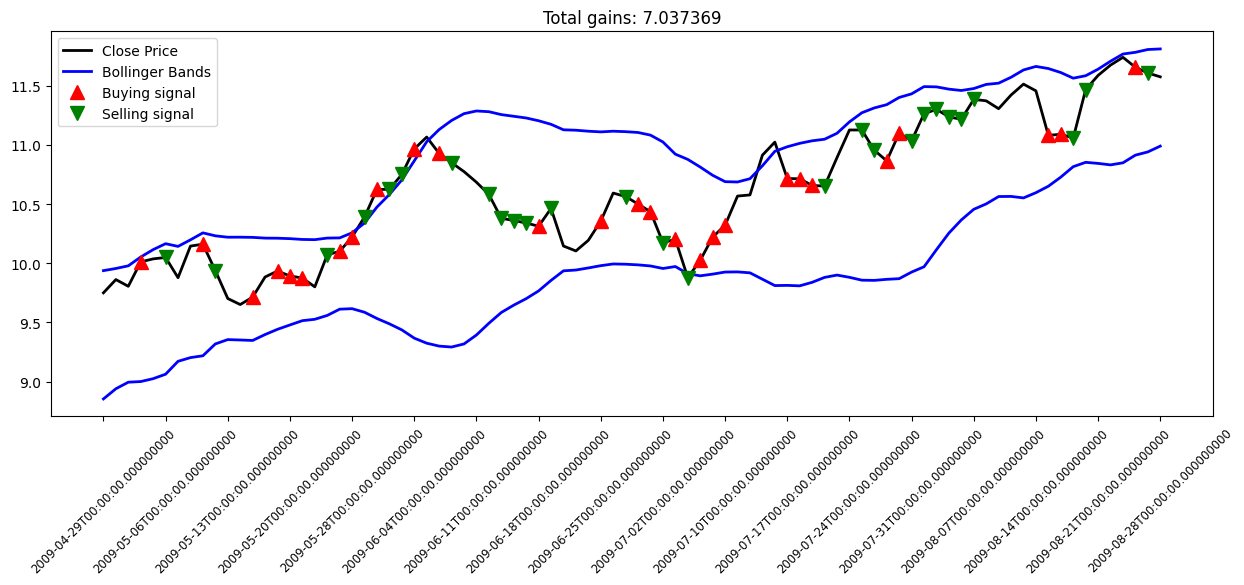

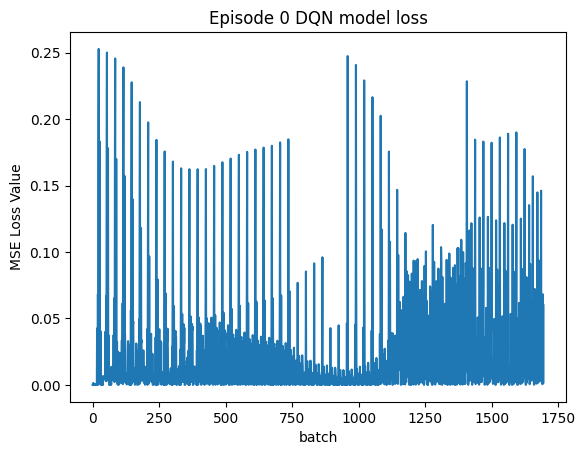

Running episode 1/2:   0%|          | 0/86 [00:00<?, ?it/s]

Buy at: $9.86
Sell at: $10.01
Profit: $0.15
Buy at: $9.70
Buy at: $9.88
Sell at: $9.93
Profit: $0.23
Sell at: $9.88
Profit: -$0.01
Buy at: $10.39
Buy at: $10.77
Buy at: $10.68
Buy at: $10.58
Sell at: $10.38
Profit: -$0.01
Buy at: $10.36
Buy at: $10.34
Sell at: $10.31
Profit: -$0.46
Sell at: $10.46
Profit: -$0.22
Buy at: $10.10
Sell at: $10.59
Profit: $0.01
Sell at: $10.56
Profit: $0.20
Sell at: $10.50
Profit: $0.16
Sell at: $10.44
Profit: $0.33
Buy at: $10.22
Buy at: $10.32
Sell at: $10.57
Profit: $0.35
Sell at: $10.91
Profit: $0.59
Buy at: $11.02
Sell at: $10.72
Profit: -$0.31
Buy at: $11.09
Sell at: $11.06
Profit: -$0.03
Buy at: $11.47
Sell at: $11.59
Profit: $0.12
--------------------------------
Episode 1
Total Profit: $1.10
Total Winners: $2.15
Total Losers: -$1.04
Max Loss: 21.745569229125977
Total Loss: 130.6070261263283
--------------------------------


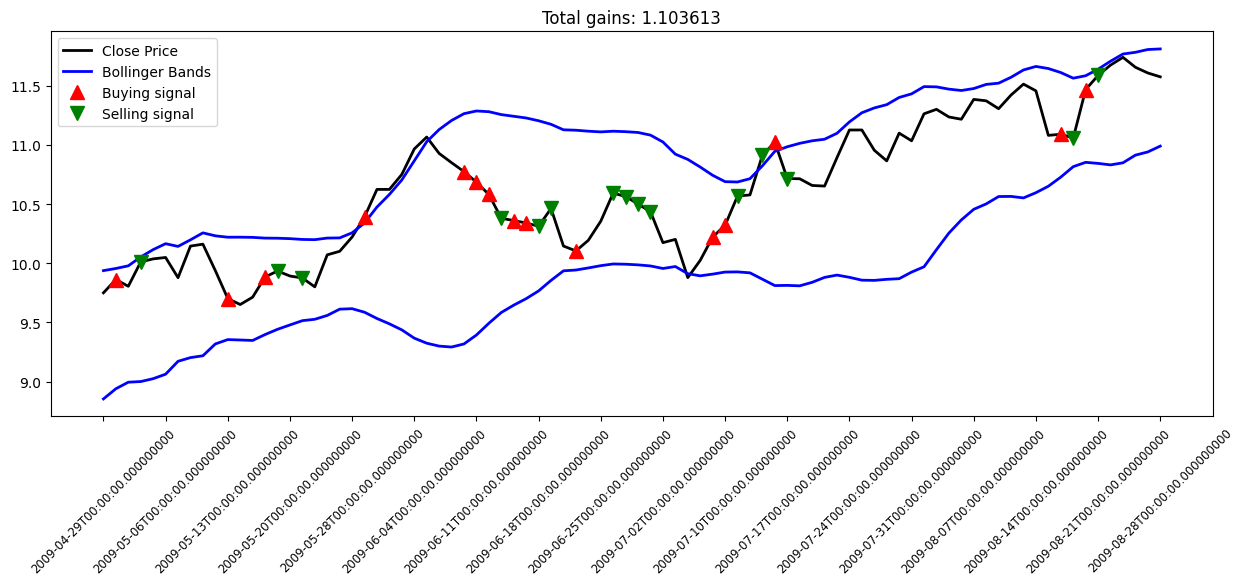

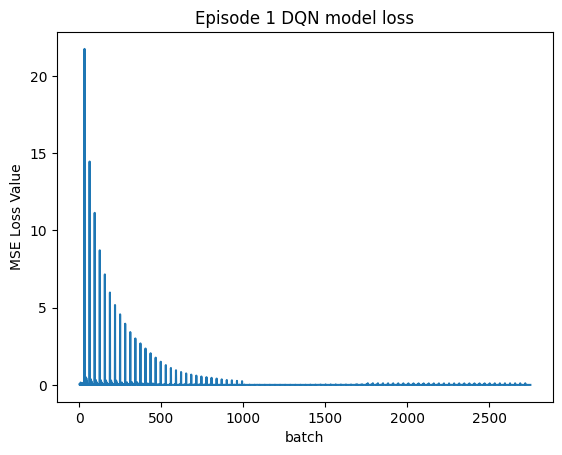

Running episode 2/2:   0%|          | 0/86 [00:00<?, ?it/s]

Buy at: $9.81
Buy at: $10.01
Buy at: $10.04
Sell at: $9.88
Profit: $0.07
Sell at: $10.15
Profit: $0.13
Sell at: $10.16
Profit: $0.12
Buy at: $9.88
Sell at: $9.80
Profit: -$0.07
Buy at: $10.62
Buy at: $10.75
Buy at: $10.97
Buy at: $11.07
Buy at: $10.93
Sell at: $10.85
Profit: $0.23
Buy at: $10.77
Sell at: $10.58
Profit: -$0.17
Sell at: $10.38
Profit: -$0.59
Sell at: $10.36
Profit: -$0.71
Sell at: $10.34
Profit: -$0.59
Sell at: $10.31
Profit: -$0.46
Buy at: $10.10
Sell at: $10.19
Profit: $0.09
Buy at: $10.87
Buy at: $11.10
Sell at: $11.26
Profit: $0.40
Buy at: $11.30
Sell at: $11.22
Profit: $0.12
Sell at: $11.38
Profit: $0.08
Buy at: $11.46
Buy at: $11.08
Sell at: $11.09
Profit: -$0.37
Sell at: $11.06
Profit: -$0.02
--------------------------------
Episode 2
Total Profit: -$1.73
Total Winners: $1.25
Total Losers: -$2.97
Max Loss: 0.39617249369621277
Total Loss: 5.6249337841834
--------------------------------


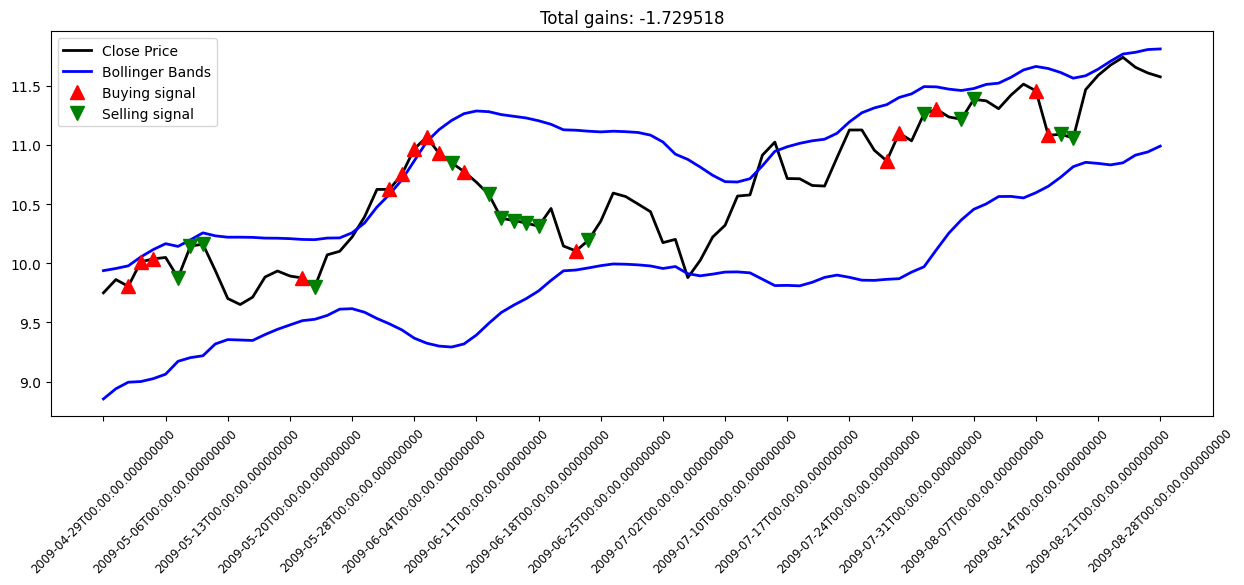

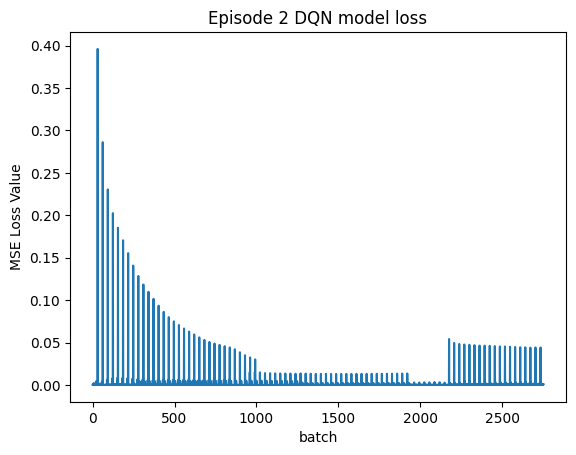

In [32]:
# track number of examples in dataset (i.e. number of days to train on)
l = X_train.shape[0]

# batch size defines how often to run the exp_replay method
batch_size = 32

# an episode represents a complete pass over the data.
episode_count = 2

# get the features normalizers from normlist
normalizer_close = normlist[idx_close]
normalizer_bb_upper = normlist[idx_bb_upper]
normalizer_bb_lower = normlist[idx_bb_lower]

# inverse transform the features in X_train in order to get true feature values
X_train_true_price = normalizer_close.inverse_transform(
    X_train[:, idx_close].reshape(-1, 1)
).flatten()
X_train_true_bb_upper = normalizer_bb_upper.inverse_transform(
    X_train[:, idx_bb_upper].reshape(-1, 1)
).flatten()
X_train_true_bb_lower = normalizer_bb_lower.inverse_transform(
    X_train[:, idx_bb_lower].reshape(-1, 1)
).flatten()

batch_losses = []
num_batches_trained = 0

for e in range(episode_count + 1):
    # state for the first step
    state = get_state(X_train, 0, window_size)
    # initialize variables
    total_profit = 0
    total_winners = 0
    total_losers = 0
    agent.inventory = []
    states_sell = []
    states_buy = []
    for t in tqdm(range(l), desc=f"Running episode {e}/{episode_count}"):
        # get the action
        action = agent.act(state)
        # get the next state
        next_state = get_state(X_train, t + 1, window_size) if t < l - 1 else state
        # initialize reward for the current time step
        reward = 0

        if action == 1:  # buy
            # inverse transform to get true buy price in dollars
            buy_price = X_train_true_price[t]
            # append the buy price to the inventory
            agent.inventory.append(buy_price)
            # append the time step to states_buy
            states_buy.append(t)
            # print the action and price of the action
            print(f"Buy at: {format_price(buy_price)}")

        elif action == 2 and len(agent.inventory) > 0:  # sell
            # get the bought price of the stock you are selling (i.e. the stock at the beginning of the inventory)
            bought_price = agent.inventory.pop(0)
            # inverse transform to get true sell price in dollars
            sell_price = X_train_true_price[t]
            # define reward as max of profit (close price at time of sell - close price at time of buy) and 0
            trade_profit = sell_price - bought_price
            reward = max(trade_profit, 0)
            # add current profit to total profit
            total_profit += trade_profit
            if trade_profit >= 0:
                # add current profit to total winners
                total_winners += trade_profit
            else:
                # add current profit to total losers
                total_losers += trade_profit
            # append the time step to states_sell
            states_sell.append(t)
            # print the action, price of the action, and profit of the action
            print(
                f"Sell at: {format_price(sell_price)}\nProfit: {format_price(trade_profit)}"
            )

        # flag for final training iteration
        done = True if t == l - 1 else False

        # append the details of the state action etc in the memory, to be used by the exp_replay function
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        # print total profit and plot behaviour of the current episode when the episode is finished
        if done:
            print("--------------------------------")
            print(f"Episode {e}")
            print(f"Total Profit: {format_price(total_profit)}")
            print(f"Total Winners: {format_price(total_winners)}")
            print(f"Total Losers: {format_price(total_losers)}")
            if len(batch_losses) > num_batches_trained:
                print(
                    f"Max Loss: {max(batch_losses[num_batches_trained:len(batch_losses)])}"
                )
                print(
                    f"Total Loss: {sum(batch_losses[num_batches_trained:len(batch_losses)])}"
                )
            else:
                print("Max Loss: 0")
                print("Total Loss: 0")
            print("--------------------------------")
            plot_behavior(
                X_train_true_price,
                X_train_true_bb_upper,
                X_train_true_bb_lower,
                states_buy,
                states_sell,
                total_profit,
            )
            plot_losses(
                batch_losses[num_batches_trained : len(batch_losses)],
                f"Episode {e} DQN model loss",
            )
            num_batches_trained = len(batch_losses)

        # when the size of the memory is greater than the batch size, run the exp_replay function on the batch to fit the model and get losses for the batch
        # then sum the losses for the batch and append them to the batch_losses list
        if len(agent.memory) > batch_size:
            losses = agent.exp_replay(batch_size, batch_losses)
            batch_losses += losses

    if e % 2 == 0:
        # save the model every 2 episodes (in case of crash or better training iteration in the middle of training process)
        agent.model.save(f"model_ep{e}.keras")

### Plot Training Loss

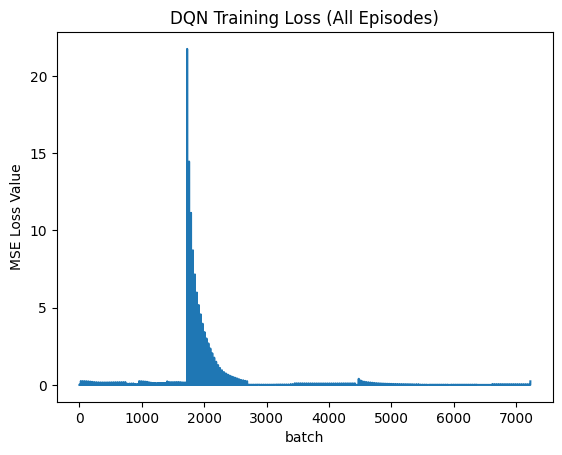

In [33]:
# use the plot_losses function to plot all batch_losses for the entire training round
plot_losses(batch_losses, "DQN Training Loss (All Episodes)")

# 9. Test the trained agent 
Finally, we get to test our trained model to see how well it performs in our test set. Using the training loop above, define a method to run our trained model on our X_test dataset. 

### Define Parameters
Some test parameters are defined for you below. Fill out the missing data. If you need a hint, look up at the training loop. 

In [40]:
l_test = len(X_test) - 1
state = get_state(X_test, 0, window_size + 1)
total_profit = 0
done = False
states_sell_test = []
states_buy_test = []

# Get the trained model
agent = Agent(
    window_size,
    num_features=X_test.shape[1],
    test_mode=True,
    model_name=f"model_ep{episode_count}.keras",
)
agent.inventory = []

# Get the first state of the test dataset
state = get_state(X_test, 0, window_size)

# Inverse transform to get true feature values for plotting
X_test_true_price = normalizer_close.inverse_transform(
    X_test[:, idx_close].reshape(-1, 1)
).flatten()
X_test_true_bb_upper = normalizer_bb_upper.inverse_transform(
    X_test[:, idx_bb_upper].reshape(-1, 1)
).flatten()
X_test_true_bb_lower = normalizer_bb_lower.inverse_transform(
    X_test[:, idx_bb_lower].reshape(-1, 1)
).flatten()

### Run the Test
Run the test data through the trained model. Look at the training loop for a hint.

------------------------------------------
Total Profit: $0.00
------------------------------------------


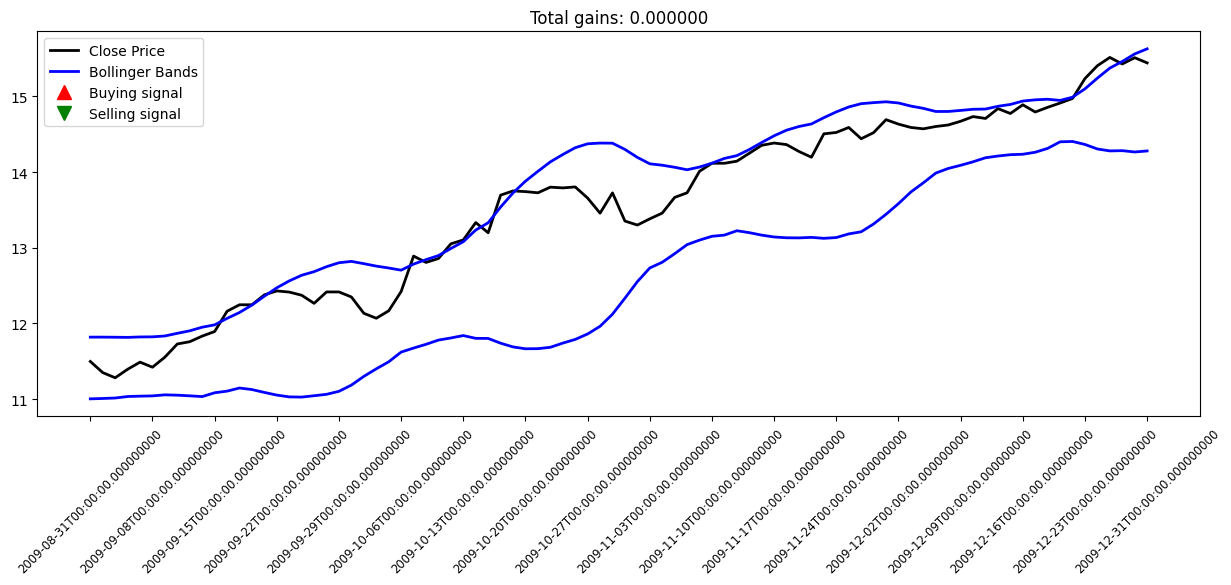

In [35]:
for t in range(l_test):
    action = agent.act(state)
    next_state = get_state(X_test, t + 1, window_size) if t < l_test - 1 else state
    reward = 0

    if action == 1:  # buy
        # inverse transform to get true buy price in dollars
        buy_price = X_test_true_price[t]
        # append buy price to inventory
        agent.inventory.append(buy_price)
        # append time step to states_buy_test
        states_buy_test.append(t)
        print(f"Buy: {format_price(buy_price)}")

    elif action == 2 and len(agent.inventory) > 0:  # sell
        # get bought price from beginning of inventory
        bought_price = agent.inventory.pop(0)
        # inverse transform to get true sell price in dollars
        sell_price = X_test_true_price[t]
        # reward is max of profit (close price at time of sell - close price at time of buy)
        reward = max(sell_price - bought_price, 0)
        # update total_test_profit
        total_profit += sell_price - bought_price
        # append time step to states_sell_test
        states_sell_test.append(t)
        print(
            f"Sell: {format_price(sell_price)} | Profit: {format_price(sell_price - bought_price)}"
        )

    if t == l_test - 1:
        done = True
    # append to memory so we can re-train on 'live' (test) data later
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print("------------------------------------------")
        print(f"Total Profit: {format_price(total_profit)}")
        print("------------------------------------------")

plot_behavior(
    X_test_true_price,
    X_test_true_bb_upper,
    X_test_true_bb_lower,
    states_buy_test,
    states_sell_test,
    total_profit,
    train=False,
)

In [36]:
test_agent = Agent(
    window_size,
    num_features=X_test.shape[1],
    test_mode=True,
    model_name=f"model_ep{episode_count}.keras",
)

print("Test agent epsilon:", test_agent.epsilon)
print("Test agent test_mode:", test_agent.test_mode)

# Test with first few states from test data
test_state = get_state(X_test, 0, window_size)
print("Test state:", test_state)

# Get Q-values for test state
test_q_values = test_agent.get_q_values_for_state(test_state)
print("Test Q-values:", test_q_values)

# Test actions for first n steps
n = 20
print(f"\nFirst {n} test actions:")
for i in range(n):
    state = get_state(X_test, i, window_size)
    action = test_agent.act(state)
    q_vals = test_agent.get_q_values_for_state(state)
    print(f"Step {i}: Action={action}, Q-values={q_vals.flatten()}")

Test agent epsilon: 1.0
Test agent test_mode: True
Test state: [0.41730687 0.41957755 0.47456684]
Test Q-values: [[0.7697689 0.7624402 0.8035855]]

First 20 test actions:
Step 0: Action=2, Q-values=[0.7697689 0.7624402 0.8035855]
Step 1: Action=2, Q-values=[0.74795026 0.741111   0.7868908 ]
Step 2: Action=2, Q-values=[0.7381012 0.7314462 0.7788814]
Step 3: Action=2, Q-values=[0.75421214 0.7471998  0.79174674]
Step 4: Action=2, Q-values=[0.7682993 0.7609672 0.8025715]
Step 5: Action=2, Q-values=[0.75840104 0.7512907  0.795007  ]
Step 6: Action=2, Q-values=[0.778478   0.77090704 0.81046677]
Step 7: Action=2, Q-values=[0.80555356 0.7974026  0.8313302 ]
Step 8: Action=2, Q-values=[0.81092566 0.80268955 0.8355526 ]
Step 9: Action=2, Q-values=[0.8233762 0.814931  0.845255 ]
Step 10: Action=2, Q-values=[0.8330698 0.8243957 0.8529513]
Step 11: Action=2, Q-values=[0.87592274 0.86640054 0.8861919 ]
Step 12: Action=2, Q-values=[0.89048475 0.88075453 0.8977975 ]
Step 13: Action=2, Q-values=[0.8925

- The Q values are too close together and the HOLD Q-value is always the highest - model learned to be neutral as it is safest
- The reward might be too conservative (either positive trade profit or zero). We can try make it a bit more aggressive, allowing also negative rewards, e.g. by simply assigning the trade profit as reward, or its percentage, divided by price.
- We start with 100 % exploration and then slowly move towards exploitation. However, we don't have much of data and we have a low number of episodes. That means the model spent too much time on choosing random actions (exploring) and no that much time with learning some actual exploited algorithm. That we could solve by:
    - Increasing the number of episodes.
    - Speeding up the epsilon decay while increasing the minimal epsilon value (so that we don't end up running multiple episodes just on 1 % of randomness).
- When selecting the mini batch, only recent experiences are used. Based on different articles, random sampling could be of some help here.


# 10. Experiment training with new parameters
Let's try different parameters for the training.

In [31]:
# First let's redefine the Agent class with some modifications:
# - adding aggressive reward
# - changing epsilon decay parameters for more exploration
# - randomly sampling the mini-batch in exp_replay from experiences


class ImprovedAgent(Agent):
    def __init__(
        self,
        window_size: int,
        num_features: int,
        test_mode: bool = False,
        model_name: str = "",
    ):
        super().__init__(window_size, num_features, test_mode, model_name)

        # More aggressive exploration parameters
        self.gamma = 0.95  # Same discount factor
        self.epsilon = 1.0  # Start with full exploration
        self.epsilon_min = 0.1  # Allow more exploration than original
        self.epsilon_decay = 0.99  # Faster decay for quicker learning

    def calculate_aggressive_reward(
        self, action: int, trade_profit: float, price: float
    ) -> float:
        """
        More aggressive reward structure that encourages trading and penalizes bad decisions
        """
        if action == 0:  # Hold
            return 0.0  # Explicitly setting no reward for holding
        elif action == 1:  # Buy
            return -0.01  # Small penalty for buying (cost of action)
        else:  # Sell (action == 2)
            # Reward based on actual profit/loss (can be negative)
            percentage_return = trade_profit / price if price > 0 else 0
            return percentage_return * 100

    def exp_replay_improved(self, batch_size: int) -> list:
        """
        Improved experience replay with the new reward structure
        """
        losses = []
        mini_batch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in mini_batch:
            if done:
                optimal_q_for_action = reward
            else:
                next_q_values = self.get_q_values_for_state(next_state)
                optimal_q_for_action = reward + self.gamma * np.amax(next_q_values)

            # Get current Q-values and update the target
            target_q_table = self.get_q_values_for_state(state)
            target_q_table[0][action] = optimal_q_for_action

            # Train the model
            history = self.fit_model(state, target_q_table)
            losses += history.history["loss"]

        # Epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return losses

In [36]:
# Create improved agent
improved_window_size = 1
improved_agent = ImprovedAgent(
    window_size=improved_window_size, num_features=num_features
)

improved_episode_count = 10  # 5x more episodes than original

improved_batch_losses = []
improved_num_batches_trained = 0

print(f"Training Parameters:")
print(f"  Episodes: {improved_episode_count} (vs original {episode_count})")
print(f"  Data points per episode: {l}")
print(f"  Total training steps: {l * improved_episode_count}")
print(
    f"  Epsilon decay: {improved_agent.epsilon_decay} (vs original {agent.epsilon_decay})"
)
print(f"  Epsilon min: {improved_agent.epsilon_min} (vs original {agent.epsilon_min})")
print("--------------------------------------")

Training Parameters:
  Episodes: 10 (vs original 2)
  Data points per episode: 86
  Total training steps: 860
  Epsilon decay: 0.99 (vs original 0.995)
  Epsilon min: 0.1 (vs original 0.01)
--------------------------------------


epsilon: 1.000


Episode 0:   0%|          | 0/86 [00:00<?, ?it/s]

--------------------------------
Episode 0
Total Profit: $3.35
Total Winners: $5.62
Total Losers: -$2.26
Max Loss: 0.23190070688724518
Total Loss: 0.2894386493636647
Actions: 21 buys, 21 sells
Epsilon: 0.5812


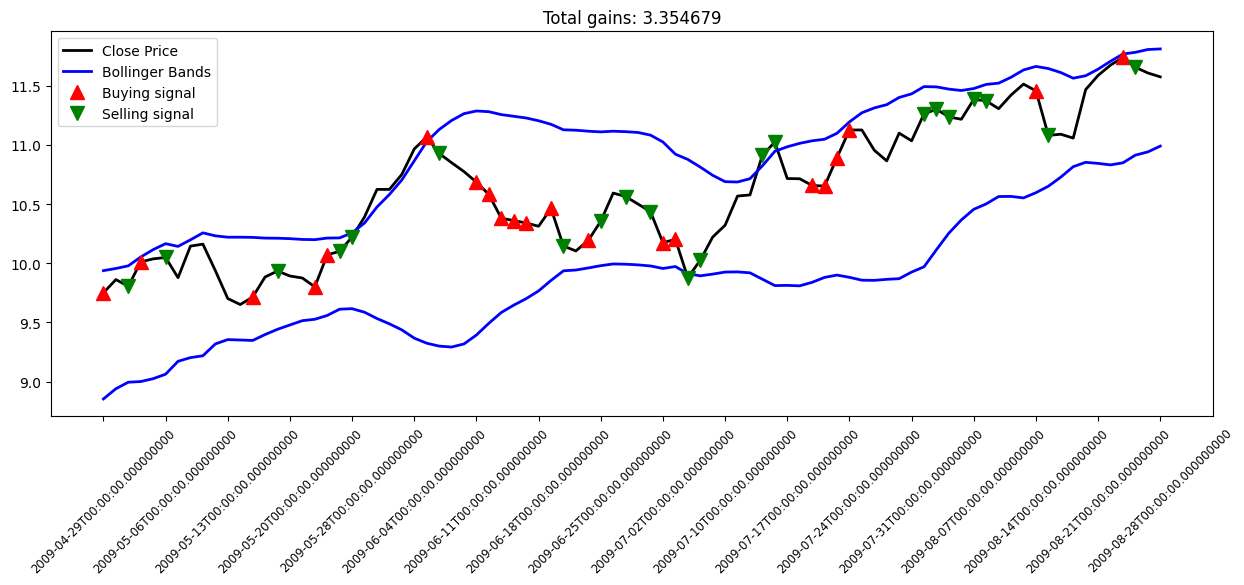

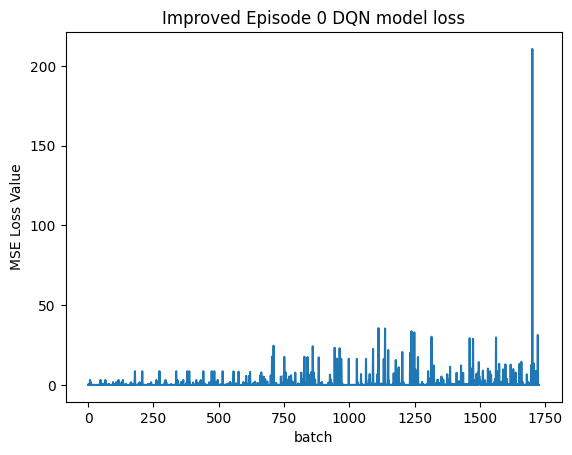

epsilon: 0.581


Episode 1:   0%|          | 0/86 [00:00<?, ?it/s]

--------------------------------
Episode 1
Total Profit: $0.57
Total Winners: $0.97
Total Losers: -$0.40
Max Loss: 0.23190070688724518
Total Loss: 0.2894386493636647
Actions: 12 buys, 12 sells
Epsilon: 0.2449
epsilon: 0.245


Episode 2:   0%|          | 0/86 [00:00<?, ?it/s]

--------------------------------
Episode 2
Total Profit: $0.89
Total Winners: $1.92
Total Losers: -$1.03
Max Loss: 0.23190070688724518
Total Loss: 0.2894386493636647
Actions: 13 buys, 13 sells
Epsilon: 0.1032


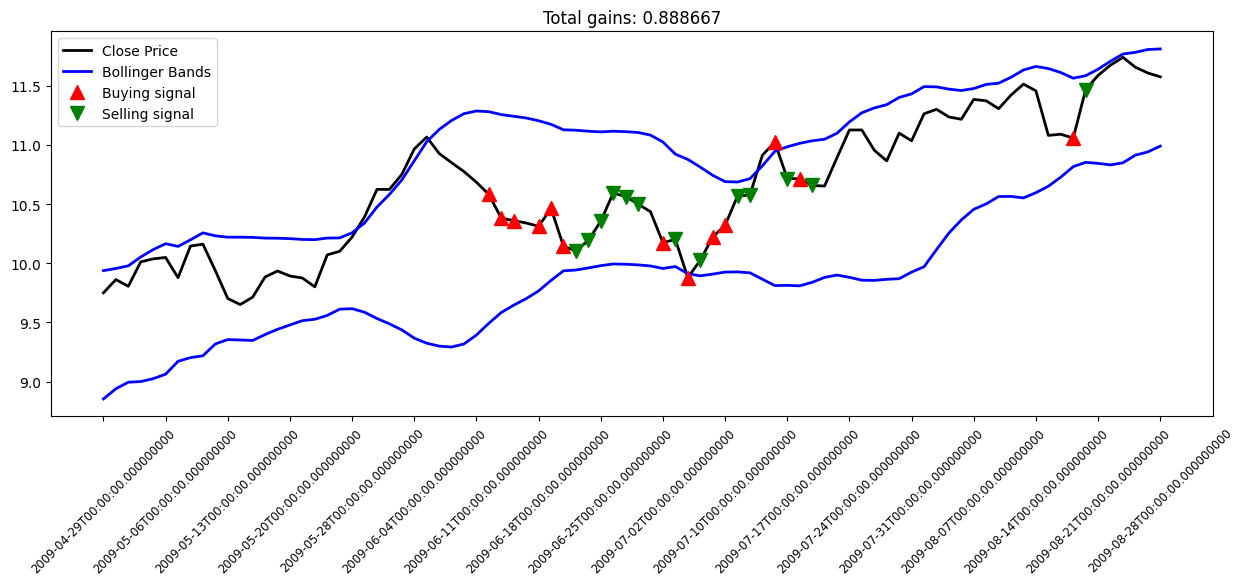

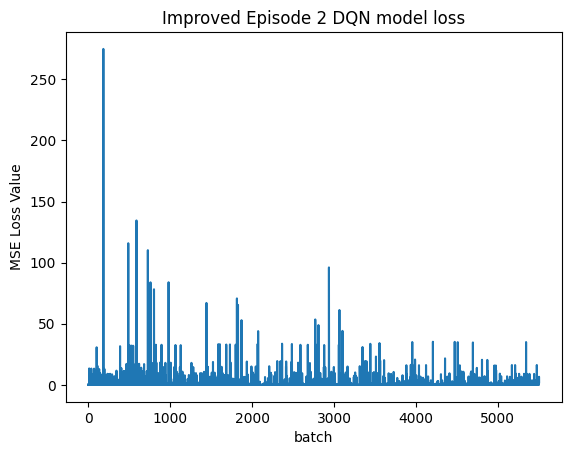

epsilon: 0.103


Episode 3:   0%|          | 0/86 [00:00<?, ?it/s]

--------------------------------
Episode 3
Total Profit: -$0.05
Total Winners: $0.21
Total Losers: -$0.26
Max Loss: 0.23190070688724518
Total Loss: 0.2894386493636647
Actions: 3 buys, 3 sells
Epsilon: 0.0991
epsilon: 0.099


Episode 4:   0%|          | 0/86 [00:00<?, ?it/s]

--------------------------------
Episode 4
Total Profit: $0.54
Total Winners: $2.14
Total Losers: -$1.60
Max Loss: 0.23190070688724518
Total Loss: 0.2894386493636647
Actions: 16 buys, 16 sells
Epsilon: 0.0991


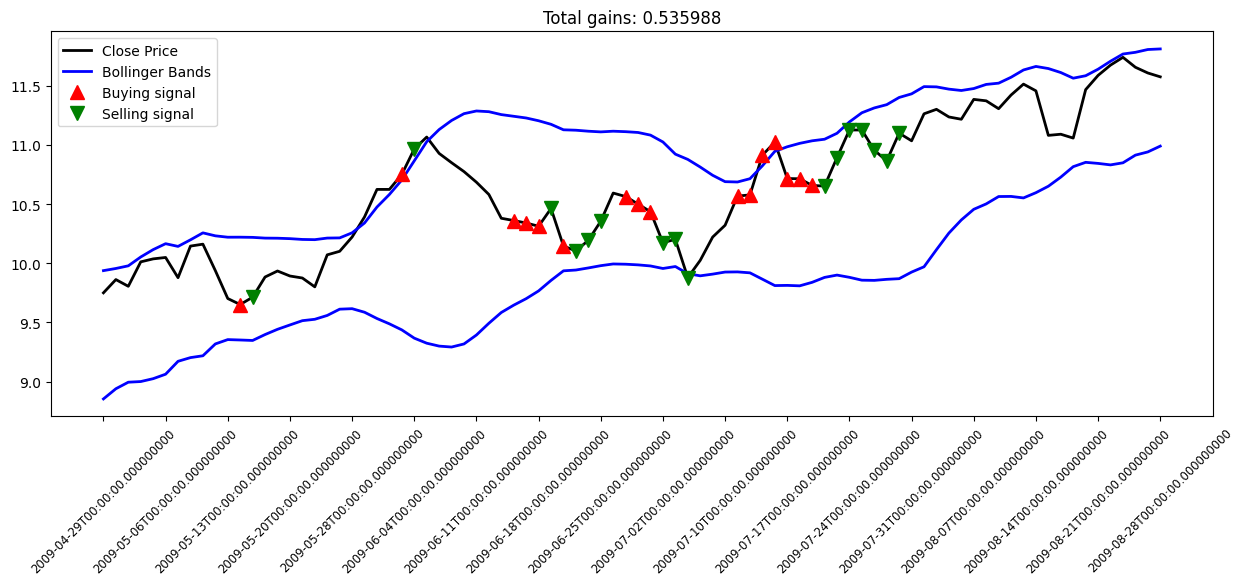

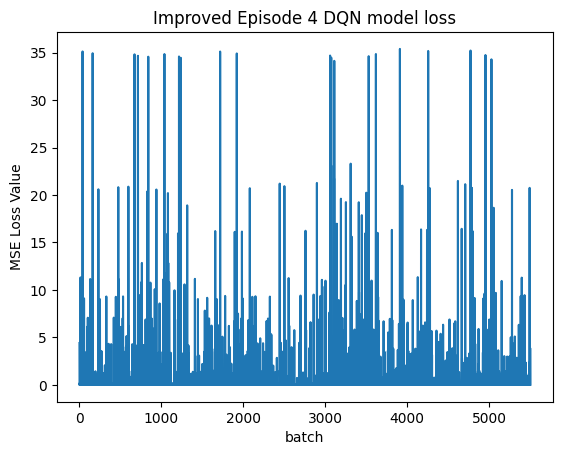

epsilon: 0.099


Episode 5:   0%|          | 0/86 [00:00<?, ?it/s]

--------------------------------
Episode 5
Total Profit: $2.34
Total Winners: $2.63
Total Losers: -$0.28
Max Loss: 0.23190070688724518
Total Loss: 0.2894386493636647
Actions: 10 buys, 9 sells
Epsilon: 0.0991
epsilon: 0.099


Episode 6:   0%|          | 0/86 [00:00<?, ?it/s]

--------------------------------
Episode 6
Total Profit: $0.24
Total Winners: $0.41
Total Losers: -$0.17
Max Loss: 0.23190070688724518
Total Loss: 0.2894386493636647
Actions: 3 buys, 3 sells
Epsilon: 0.0991


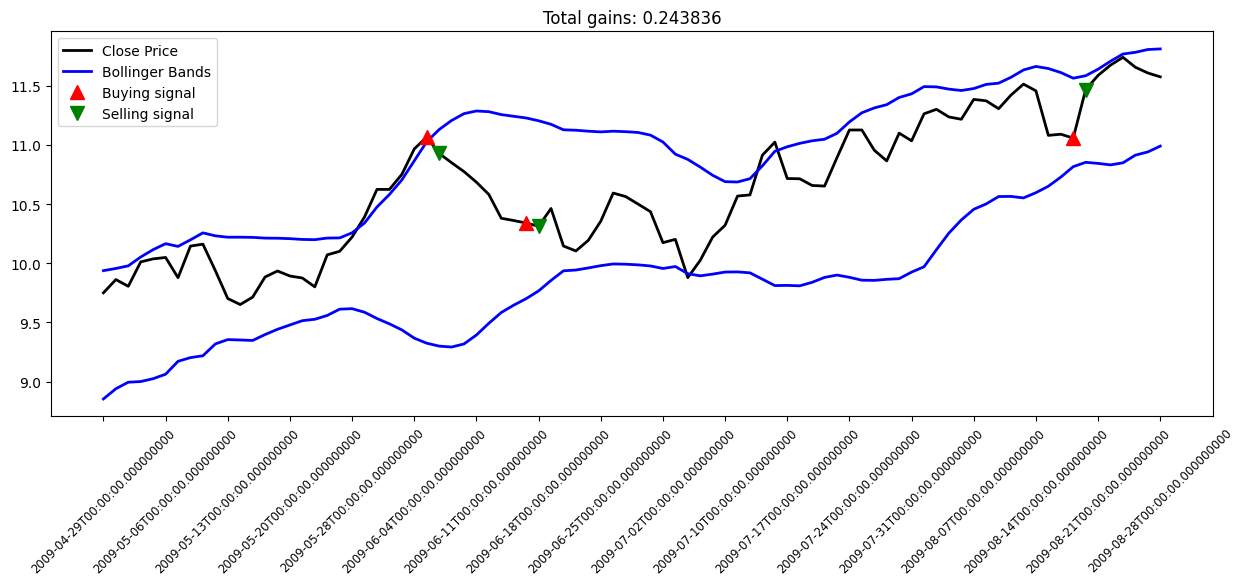

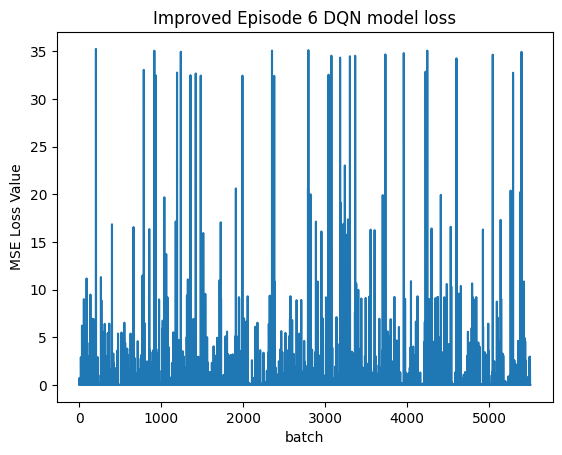

epsilon: 0.099


Episode 7:   0%|          | 0/86 [00:00<?, ?it/s]

--------------------------------
Episode 7
Total Profit: $0.28
Total Winners: $0.28
Total Losers: $0.00
Max Loss: 0.23190070688724518
Total Loss: 0.2894386493636647
Actions: 2 buys, 2 sells
Epsilon: 0.0991
epsilon: 0.099


Episode 8:   0%|          | 0/86 [00:00<?, ?it/s]

--------------------------------
Episode 8
Total Profit: $0.21
Total Winners: $0.27
Total Losers: -$0.06
Max Loss: 0.23190070688724518
Total Loss: 0.2894386493636647
Actions: 2 buys, 2 sells
Epsilon: 0.0991


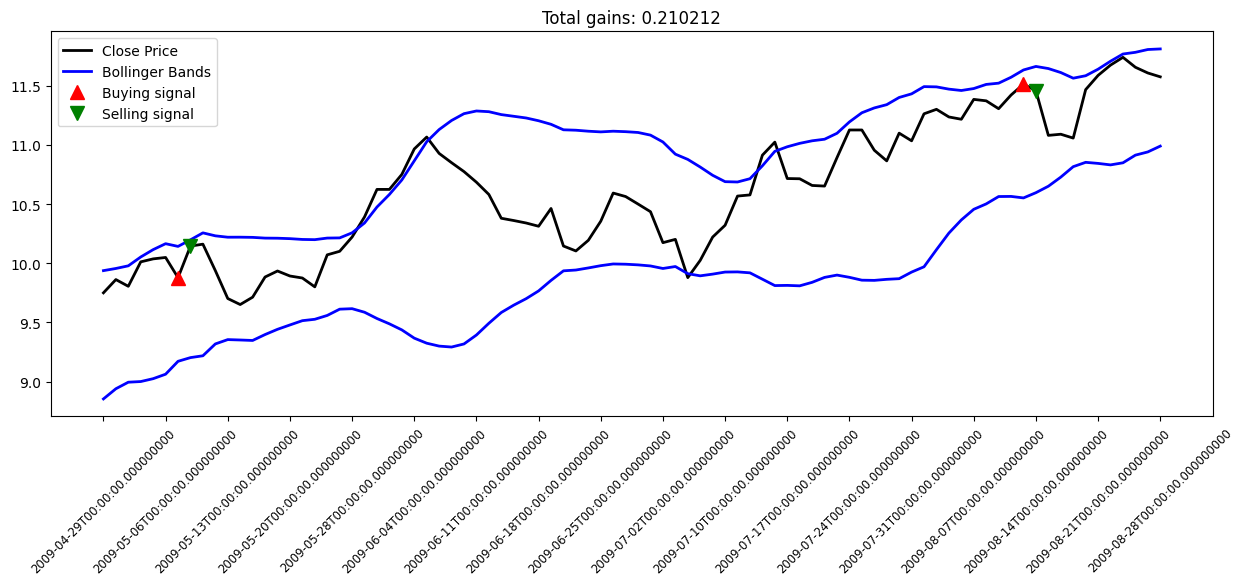

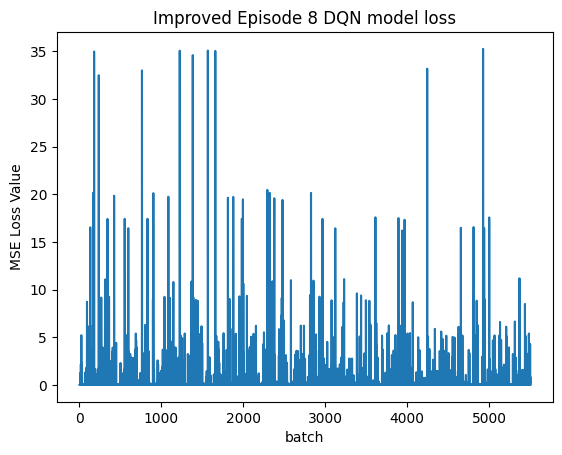

epsilon: 0.099


Episode 9:   0%|          | 0/86 [00:00<?, ?it/s]

--------------------------------
Episode 9
Total Profit: $0.12
Total Winners: $0.12
Total Losers: $0.00
Max Loss: 0.23190070688724518
Total Loss: 0.2894386493636647
Actions: 2 buys, 2 sells
Epsilon: 0.0991
epsilon: 0.099


Episode 10:   0%|          | 0/86 [00:00<?, ?it/s]

--------------------------------
Episode 10
Total Profit: $2.66
Total Winners: $2.90
Total Losers: -$0.24
Max Loss: 0.23190070688724518
Total Loss: 0.2894386493636647
Actions: 11 buys, 9 sells
Epsilon: 0.0991


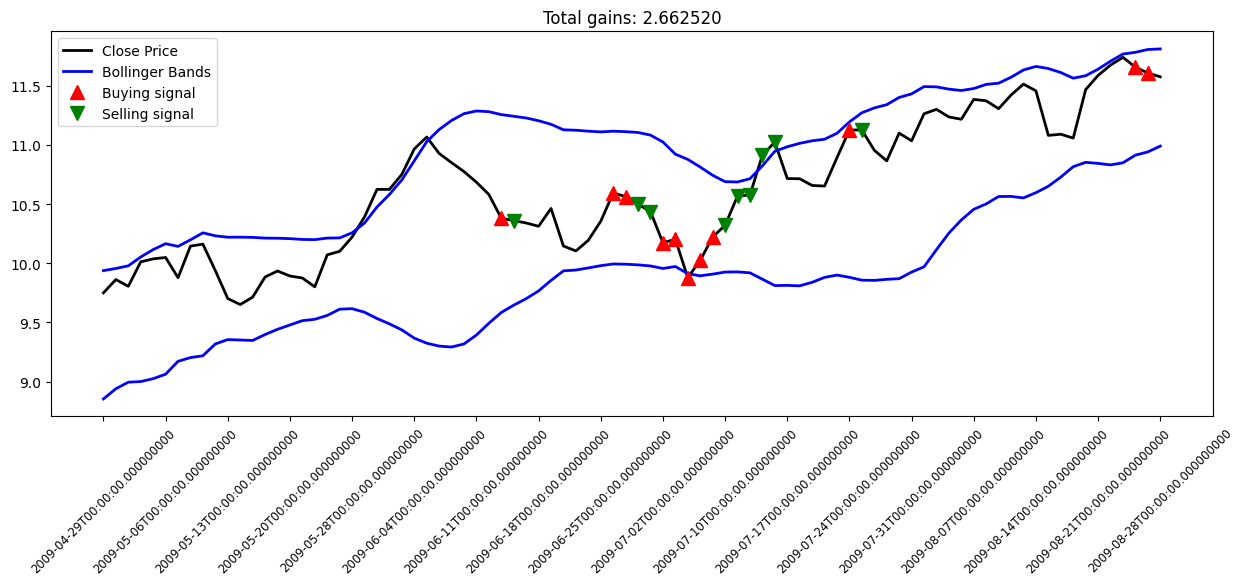

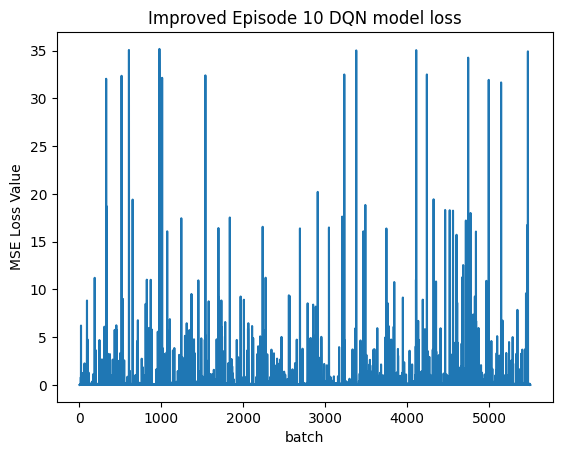

In [45]:
for e in range(improved_episode_count + 1):
    state = get_state(X_train, 0, improved_window_size)
    total_profit = 0
    total_winners = 0
    total_losers = 0
    improved_agent.inventory = []
    states_sell = []
    states_buy = []

    print(f"epsilon: {improved_agent.epsilon:.3f}")
    for t in tqdm(range(l), desc=f"Episode {e}", leave=False):
        action = improved_agent.act(state)
        next_state = (
            get_state(X_train, t + 1, improved_window_size) if t < l - 1 else state
        )
        reward = 0
        current_price = X_train_true_price[t]

        if action == 1:  # Buy
            improved_agent.inventory.append(current_price)
            states_buy.append(t)
            # Use new reward calculation
            reward = improved_agent.calculate_aggressive_reward(
                action, 0, current_price
            )

        elif action == 2 and len(improved_agent.inventory) > 0:  # Sell
            bought_price = improved_agent.inventory.pop(0)
            trade_profit = current_price - bought_price
            total_profit += trade_profit
            if trade_profit >= 0:
                total_winners += trade_profit
            else:
                total_losers += trade_profit
            states_sell.append(t)
            # Use improved reward calculation - allows negative rewards!
            reward = improved_agent.calculate_aggressive_reward(
                action, trade_profit, bought_price
            )
        else:
            # Hold action
            reward = improved_agent.calculate_aggressive_reward(
                action, 0, current_price
            )
        done = True if t == l - 1 else False
        improved_agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if len(improved_agent.memory) > batch_size:
            losses = improved_agent.exp_replay_improved(batch_size)
            improved_batch_losses += losses

        # Episode summary
        if done:
            print("--------------------------------")
            print(f"Episode {e}")
            print(f"Total Profit: {format_price(total_profit)}")
            print(f"Total Winners: {format_price(total_winners)}")
            print(f"Total Losers: {format_price(total_losers)}")
            if len(batch_losses) > num_batches_trained:
                print(
                    f"Max Loss: {max(batch_losses[num_batches_trained:len(batch_losses)])}"
                )
                print(
                    f"Total Loss: {sum(batch_losses[num_batches_trained:len(batch_losses)])}"
                )
            else:
                print("Max Loss: 0")
                print("Total Loss: 0")
            print(f"Actions: {len(states_buy)} buys, {len(states_sell)} sells")
            print(f"Epsilon: {improved_agent.epsilon:.4f}")

            # Plot every 2 episodes to monitor progress
            if e % 2 == 0:
                plot_behavior(
                    X_train_true_price,
                    X_train_true_bb_upper,
                    X_train_true_bb_lower,
                    states_buy,
                    states_sell,
                    total_profit,
                    train=True,
                )
                if len(improved_batch_losses) > improved_num_batches_trained:
                    plot_losses(
                        improved_batch_losses[improved_num_batches_trained:],
                        f"Improved Episode {e} DQN model loss",
                    )
                improved_num_batches_trained = len(improved_batch_losses)

    if e % 2 == 0:
        improved_agent.model.save(f"improved_model_ep{e}.keras")

In [46]:
print(f"Final epsilon: {improved_agent.epsilon:.4f}")
print(f"Total training losses: {len(improved_batch_losses)}")

Final epsilon: 0.0991
Total training losses: 29248


In [42]:
l_test_improved = len(X_test) - 1
improved_test_agent = ImprovedAgent(
    window_size=improved_window_size,
    num_features=X_test.shape[1],
    test_mode=True,
    model_name=f"improved_model_ep{improved_episode_count}.keras",
)

improved_test_agent.inventory = []
total_profit_improved = 0
states_sell_test_improved = []
states_buy_test_improved = []

print("\n First 10 Test Q-Values:")
for i in range(10):
    test_state = get_state(X_test, i, improved_window_size)
    q_vals = improved_test_agent.get_q_values_for_state(test_state)
    action = improved_test_agent.act(test_state)
    print(f"  Step {i}: Action={action}, Q-values={q_vals.flatten()}")

print("\nRunning Test Trading...")
state = get_state(X_test, 0, improved_window_size)
for t in tqdm(range(l_test_improved), desc="Testing"):
    action = improved_test_agent.act(state)
    next_state = (
        get_state(X_test, t + 1, improved_window_size)
        if t < l_test_improved - 1
        else state
    )

    if action == 1:  # Buy
        buy_price = X_test_true_price[t]
        improved_test_agent.inventory.append(buy_price)
        states_buy_test_improved.append(t)
        print(f"✅ Buy: {format_price(buy_price)} at step {t}")

    elif action == 2 and len(improved_test_agent.inventory) > 0:  # Sell
        bought_price = improved_test_agent.inventory.pop(0)
        sell_price = X_test_true_price[t]
        profit = sell_price - bought_price
        total_profit_improved += profit
        states_sell_test_improved.append(t)
        print(
            f"💰 Sell: {format_price(sell_price)} | Profit: {format_price(profit)} at step {t}"
        )

    state = next_state


 First 10 Test Q-Values:
  Step 0: Action=2, Q-values=[2.0830584 2.0595734 2.1747587]
  Step 1: Action=2, Q-values=[1.7915956 1.7537359 1.8396783]
  Step 2: Action=2, Q-values=[1.6572807 1.6130297 1.6854384]
  Step 3: Action=2, Q-values=[1.8592285 1.8256234 1.9181234]
  Step 4: Action=2, Q-values=[2.0290082 2.0040545 2.1135197]
  Step 5: Action=2, Q-values=[1.8931181 1.8615229 1.957339 ]
  Step 6: Action=2, Q-values=[2.1238863 2.1043537 2.223154 ]
  Step 7: Action=2, Q-values=[2.416051  2.4112127 2.5592554]
  Step 8: Action=2, Q-values=[2.42833   2.423989  2.5732906]
  Step 9: Action=2, Q-values=[2.5067718 2.5062735 2.6634514]

Running Test Trading...


Testing:   0%|          | 0/85 [00:00<?, ?it/s]

✅ Buy: $13.46 at step 41
✅ Buy: $13.72 at step 42
✅ Buy: $13.35 at step 43
✅ Buy: $13.30 at step 44
✅ Buy: $13.38 at step 45
✅ Buy: $13.46 at step 46
✅ Buy: $13.67 at step 47
✅ Buy: $13.73 at step 48
💰 Sell: $14.01 | Profit: $0.55 at step 49
💰 Sell: $14.12 | Profit: $0.39 at step 50
✅ Buy: $14.12 at step 51
✅ Buy: $14.14 at step 52
✅ Buy: $14.25 at step 53
💰 Sell: $14.35 | Profit: $1.00 at step 54
✅ Buy: $14.38 at step 55
✅ Buy: $14.36 at step 56
✅ Buy: $14.27 at step 57
✅ Buy: $14.20 at step 58
✅ Buy: $14.50 at step 59
✅ Buy: $14.52 at step 60
✅ Buy: $14.59 at step 61
✅ Buy: $14.44 at step 62
✅ Buy: $14.52 at step 63
✅ Buy: $14.69 at step 64
✅ Buy: $14.63 at step 65
✅ Buy: $14.59 at step 66
✅ Buy: $14.57 at step 67
✅ Buy: $14.60 at step 68
✅ Buy: $14.62 at step 69
✅ Buy: $14.67 at step 70
✅ Buy: $14.73 at step 71
✅ Buy: $14.71 at step 72
✅ Buy: $14.84 at step 73
✅ Buy: $14.77 at step 74
✅ Buy: $14.89 at step 75
✅ Buy: $14.79 at step 76
✅ Buy: $14.85 at step 77
✅ Buy: $14.91 at step 78

In [44]:
print(f"Total Profit: {format_price(total_profit_improved)}")
print(f"Buy Actions: {len(states_buy_test_improved)}")
print(f"Sell Actions: {len(states_sell_test_improved)}")

Total Profit: $1.94
Buy Actions: 41
Sell Actions: 3


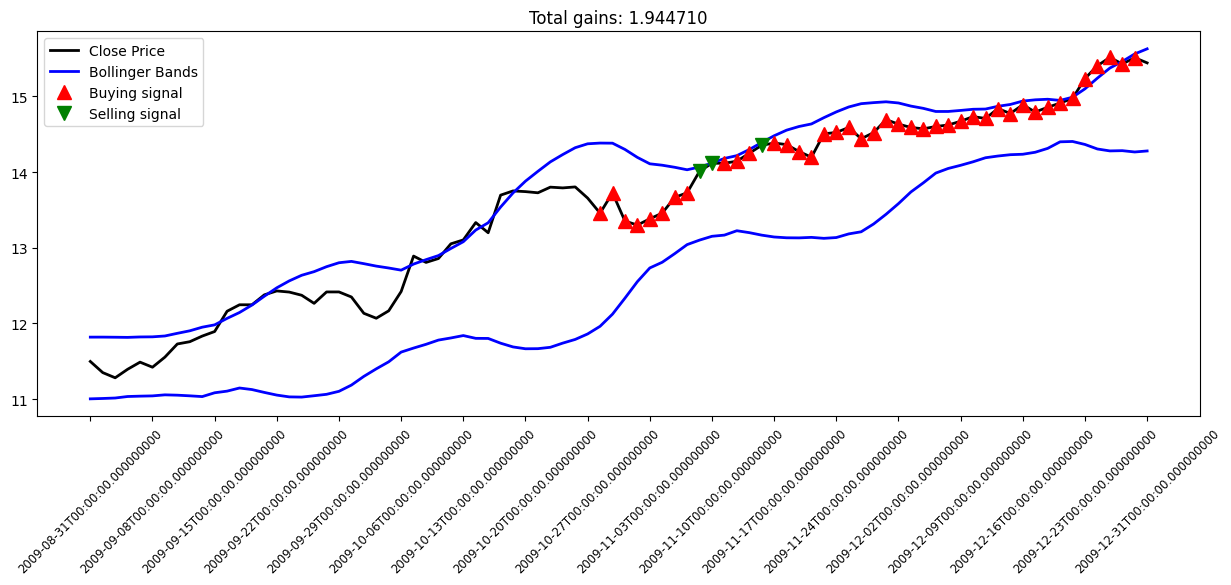

In [46]:
# Plot improved results
plot_behavior(
    X_test_true_price,
    X_test_true_bb_upper,
    X_test_true_bb_lower,
    states_buy_test_improved,
    states_sell_test_improved,
    total_profit_improved,
    train=False,
)

- As we can see, the model actually improved - it now does SOMETHING. It learned to buy a lot and sell when it makes sense. Therefore we can see a positive profit.
- However, the model keeps on holding a lot of bought assets, which were not sold.

In [48]:
len(improved_test_agent.inventory)

38

- This happened because we didn't tell the model to "not buy so much". The reward function gives only a small penalty for buy orders (-0.01). If we were about to decrease the risk that's coming from the big amount of held assets, we would need to change that part of reward function.

In [55]:
class SecondImprovedAgent(Agent):
    def __init__(
        self,
        window_size: int,
        num_features: int,
        test_mode: bool = False,
        model_name: str = "",
    ):
        super().__init__(window_size, num_features, test_mode, model_name)

        # More aggressive exploration parameters
        self.gamma = 0.95  # Same discount factor
        self.epsilon = 1.0  # Start with full exploration
        self.epsilon_min = 0.1  # Allow more exploration than original
        self.epsilon_decay = 0.99  # Faster decay for quicker learning

    def calculate_aggressive_reward(
        self, action: int, trade_profit: float, price: float
    ) -> float:
        """
        More aggressive reward structure that encourages trading and penalizes bad decisions
        """
        if action == 0:  # Hold
            return 0.0  # Explicitly setting no reward for holding
        elif action == 1:  # Buy
            return -100  # Bigger penalty for buying (cost of action)
        else:  # Sell (action == 2)
            # Reward based on actual profit/loss (can be negative)
            percentage_return = trade_profit / price if price > 0 else 0
            return percentage_return * 100

    def exp_replay_improved(self, batch_size: int) -> list:
        """
        Improved experience replay with the new reward structure
        """
        losses = []
        mini_batch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in mini_batch:
            if done:
                optimal_q_for_action = reward
            else:
                next_q_values = self.get_q_values_for_state(next_state)
                optimal_q_for_action = reward + self.gamma * np.amax(next_q_values)

            # Get current Q-values and update the target
            target_q_table = self.get_q_values_for_state(state)
            target_q_table[0][action] = optimal_q_for_action

            # Train the model
            history = self.fit_model(state, target_q_table)
            losses += history.history["loss"]

        # Epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return losses

In [56]:
# Create second improved agent
second_improved_window_size = 1
second_improved_agent = SecondImprovedAgent(
    window_size=second_improved_window_size, num_features=num_features
)

second_improved_episode_count = 4

second_improved_batch_losses = []
second_improved_num_batches_trained = 0

print(f"Training Parameters:")
print(f"  Episodes: {second_improved_episode_count} (vs original {episode_count})")
print(f"  Data points per episode: {l}")
print(f"  Total training steps: {l * second_improved_episode_count}")
print(
    f"  Epsilon decay: {second_improved_agent.epsilon_decay} (vs original {agent.epsilon_decay})"
)
print(
    f"  Epsilon min: {second_improved_agent.epsilon_min} (vs original {agent.epsilon_min})"
)
print("--------------------------------------")

Training Parameters:
  Episodes: 4 (vs original 2)
  Data points per episode: 86
  Total training steps: 344
  Epsilon decay: 0.99 (vs original 0.995)
  Epsilon min: 0.1 (vs original 0.01)
--------------------------------------


epsilon: 1.000


Episode 0:   0%|          | 0/86 [00:00<?, ?it/s]

--------------------------------
Episode 0
Total Profit: $1.30
Total Winners: $5.00
Total Losers: -$3.70
Max Loss: 3331.28125
Total Loss: 289628.51963513426
Actions: 27 buys, 27 sells
Epsilon: 0.5812


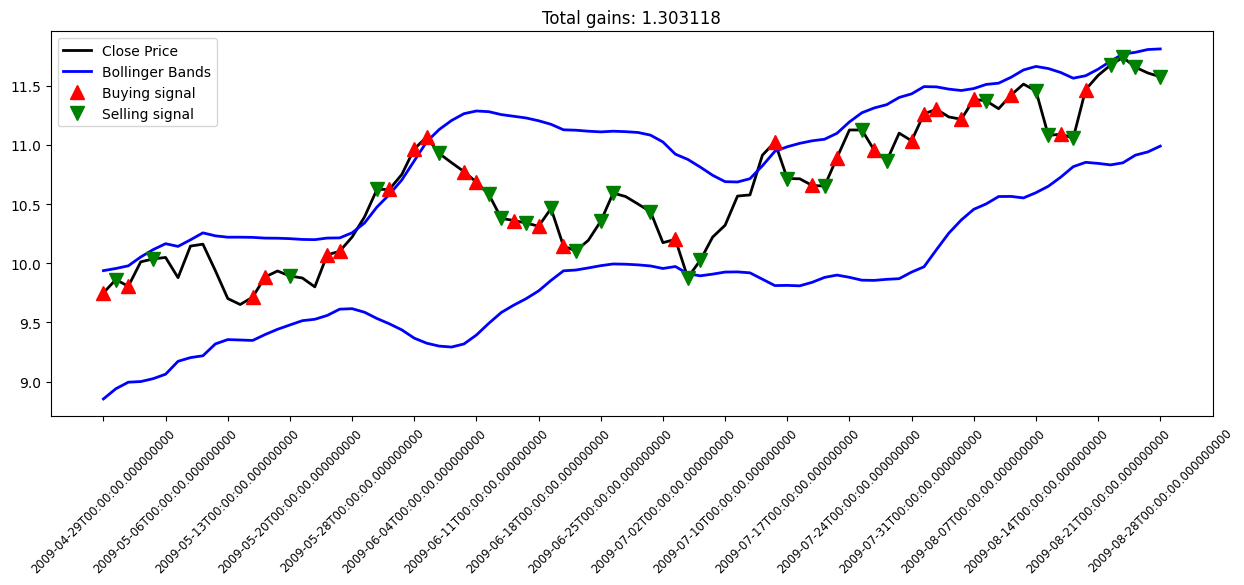

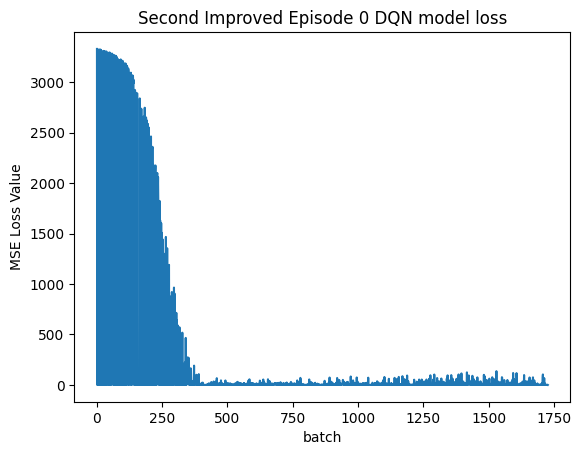

epsilon: 0.581


Episode 1:   0%|          | 0/86 [00:00<?, ?it/s]

--------------------------------
Episode 1
Total Profit: -$0.62
Total Winners: $0.28
Total Losers: -$0.90
Max Loss: 123.26160430908203
Total Loss: 15517.036972600048
Actions: 9 buys, 8 sells
Epsilon: 0.2449
epsilon: 0.245


Episode 2:   0%|          | 0/86 [00:00<?, ?it/s]

--------------------------------
Episode 2
Total Profit: $0.47
Total Winners: $0.85
Total Losers: -$0.38
Max Loss: 123.26160430908203
Total Loss: 20307.585886037654
Actions: 5 buys, 5 sells
Epsilon: 0.1032


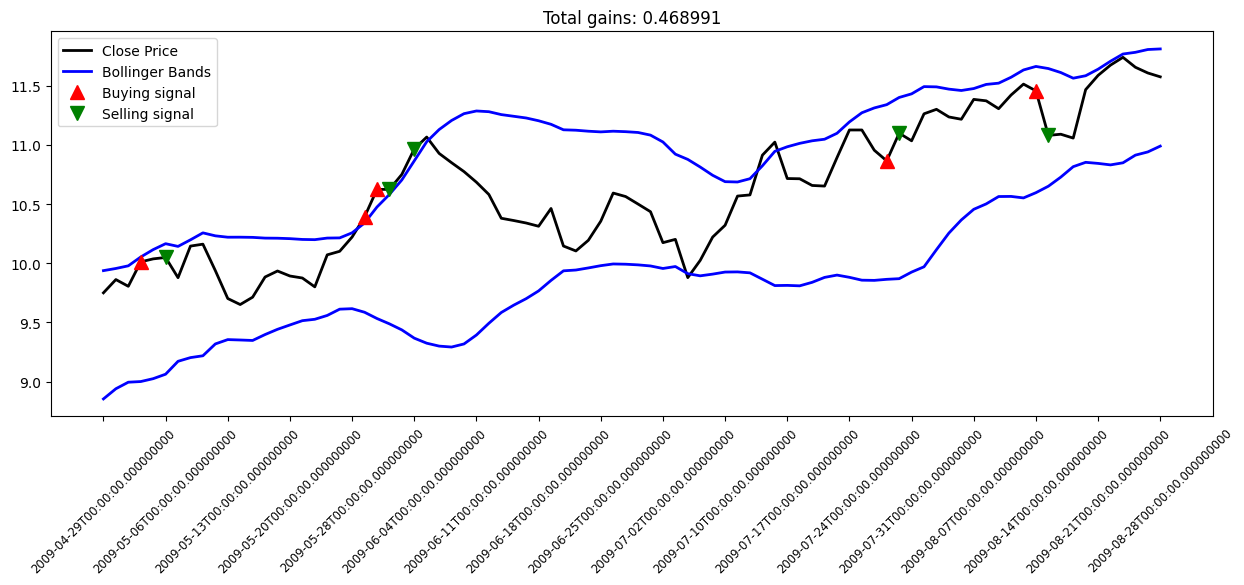

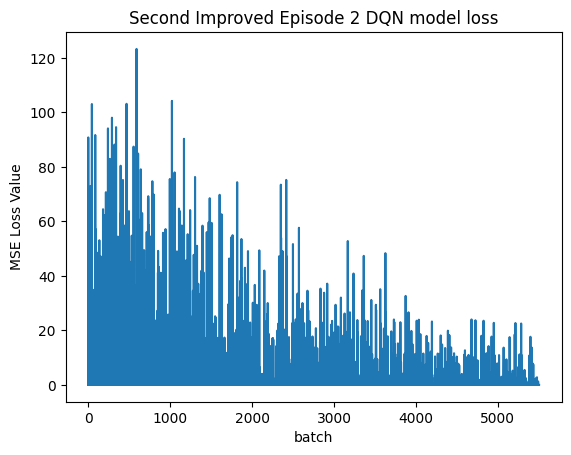

epsilon: 0.103


Episode 3:   0%|          | 0/86 [00:00<?, ?it/s]

--------------------------------
Episode 3
Total Profit: $0.30
Total Winners: $0.32
Total Losers: -$0.02
Max Loss: 24.8889102935791
Total Loss: 2098.1404397185306
Actions: 2 buys, 2 sells
Epsilon: 0.0991
epsilon: 0.099


Episode 4:   0%|          | 0/86 [00:00<?, ?it/s]

--------------------------------
Episode 4
Total Profit: -$0.39
Total Winners: $0.00
Total Losers: -$0.39
Max Loss: 24.977846145629883
Total Loss: 3394.2486932752213
Actions: 3 buys, 3 sells
Epsilon: 0.0991


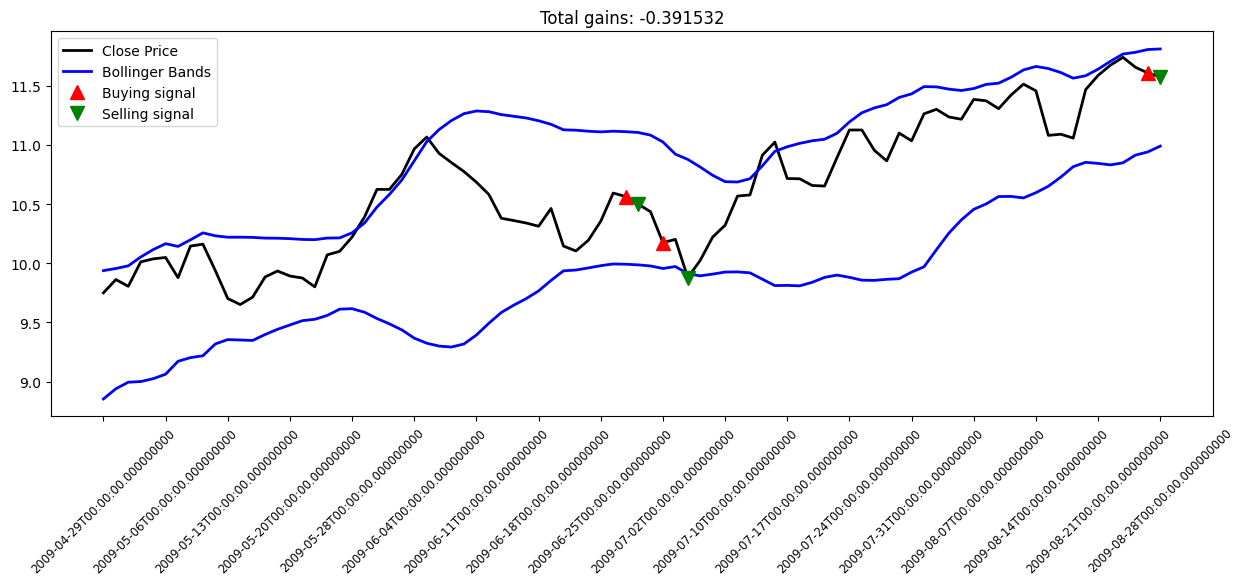

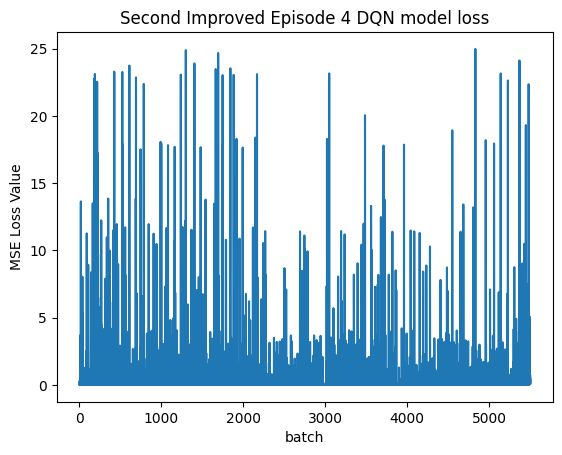

In [57]:
for e in range(second_improved_episode_count + 1):
    state = get_state(X_train, 0, second_improved_window_size)
    total_profit = 0
    total_winners = 0
    total_losers = 0
    second_improved_agent.inventory = []
    states_sell = []
    states_buy = []

    print(f"epsilon: {second_improved_agent.epsilon:.3f}")
    for t in tqdm(range(l), desc=f"Episode {e}", leave=False):
        action = second_improved_agent.act(state)
        next_state = (
            get_state(X_train, t + 1, second_improved_window_size)
            if t < l - 1
            else state
        )
        reward = 0
        current_price = X_train_true_price[t]

        if action == 1:  # Buy
            second_improved_agent.inventory.append(current_price)
            states_buy.append(t)
            # Use new reward calculation
            reward = second_improved_agent.calculate_aggressive_reward(
                action, 0, current_price
            )

        elif action == 2 and len(second_improved_agent.inventory) > 0:  # Sell
            bought_price = second_improved_agent.inventory.pop(0)
            trade_profit = current_price - bought_price
            total_profit += trade_profit
            if trade_profit >= 0:
                total_winners += trade_profit
            else:
                total_losers += trade_profit
            states_sell.append(t)
            # Use improved reward calculation - allows negative rewards!
            reward = second_improved_agent.calculate_aggressive_reward(
                action, trade_profit, bought_price
            )
        else:
            # Hold action
            reward = second_improved_agent.calculate_aggressive_reward(
                action, 0, current_price
            )
        done = True if t == l - 1 else False
        second_improved_agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if len(second_improved_agent.memory) > batch_size:
            losses = second_improved_agent.exp_replay_improved(batch_size)
            second_improved_batch_losses += losses

        # Episode summary
        if done:
            print("--------------------------------")
            print(f"Episode {e}")
            print(f"Total Profit: {format_price(total_profit)}")
            print(f"Total Winners: {format_price(total_winners)}")
            print(f"Total Losers: {format_price(total_losers)}")
            if len(second_improved_batch_losses) > second_improved_num_batches_trained:
                print(
                    f"Max Loss: {max(second_improved_batch_losses[second_improved_num_batches_trained:len(second_improved_batch_losses)])}"
                )
                print(
                    f"Total Loss: {sum(second_improved_batch_losses[second_improved_num_batches_trained:len(second_improved_batch_losses)])}"
                )
            else:
                print("Max Loss: 0")
                print("Total Loss: 0")
            print(f"Actions: {len(states_buy)} buys, {len(states_sell)} sells")
            print(f"Epsilon: {second_improved_agent.epsilon:.4f}")

            # Plot every 2 episodes to monitor progress
            if e % 2 == 0:
                plot_behavior(
                    X_train_true_price,
                    X_train_true_bb_upper,
                    X_train_true_bb_lower,
                    states_buy,
                    states_sell,
                    total_profit,
                    train=True,
                )
                if (
                    len(second_improved_batch_losses)
                    > second_improved_num_batches_trained
                ):
                    plot_losses(
                        second_improved_batch_losses[
                            second_improved_num_batches_trained:
                        ],
                        f"Second Improved Episode {e} DQN model loss",
                    )
                second_improved_num_batches_trained = len(second_improved_batch_losses)

    if e % 2 == 0:
        second_improved_agent.model.save(f"second_improved_model_ep{e}.keras")

In [61]:
# Test the second improved agent
l_test_second_improved = len(X_test) - 1
second_improved_test_agent = SecondImprovedAgent(
    window_size=second_improved_window_size,
    num_features=X_test.shape[1],
    test_mode=True,
    model_name=f"second_improved_model_ep{second_improved_episode_count}.keras",
)

second_improved_test_agent.inventory = []
total_profit_second_improved = 0
states_sell_test_second_improved = []
states_buy_test_second_improved = []

print("\n First 10 Test Q-Values:")
for i in range(10):
    test_state = get_state(X_test, i, second_improved_window_size)
    q_vals = second_improved_test_agent.get_q_values_for_state(test_state)
    action = second_improved_test_agent.act(test_state)
    print(f"  Step {i}: Action={action}, Q-values={q_vals.flatten()}")

print("\nRunning Test Trading...")
state = get_state(X_test, 0, second_improved_window_size)
for t in tqdm(range(l_test_second_improved), desc="Testing"):
    action = second_improved_test_agent.act(state)
    next_state = (
        get_state(X_test, t + 1, second_improved_window_size)
        if t < l_test_second_improved - 1
        else state
    )

    if action == 1:  # Buy
        buy_price = X_test_true_price[t]
        second_improved_test_agent.inventory.append(buy_price)
        states_buy_test_second_improved.append(t)
        print(f"✅ Buy: {format_price(buy_price)} at step {t}")

    elif action == 2 and len(second_improved_test_agent.inventory) > 0:  # Sell
        bought_price = second_improved_test_agent.inventory.pop(0)
        sell_price = X_test_true_price[t]
        profit = sell_price - bought_price
        total_profit_second_improved += profit
        states_sell_test_second_improved.append(t)
        print(
            f"💰 Sell: {format_price(sell_price)} | Profit: {format_price(profit)} at step {t}"
        )

    state = next_state


 First 10 Test Q-Values:
  Step 0: Action=2, Q-values=[  7.351054 -92.21148    8.712266]
  Step 1: Action=2, Q-values=[  7.342131 -92.096825   8.701881]
  Step 2: Action=2, Q-values=[  7.338218 -92.04481    8.697115]
  Step 3: Action=2, Q-values=[  7.3451653 -92.14187     8.705465 ]
  Step 4: Action=2, Q-values=[  7.3501124 -92.20793     8.711176 ]
  Step 5: Action=2, Q-values=[  7.3458686 -92.1549      8.706324 ]
  Step 6: Action=2, Q-values=[  7.35249  -92.2452     8.713911]
  Step 7: Action=2, Q-values=[  7.3586664 -92.33176     8.721058 ]
  Step 8: Action=2, Q-values=[  7.3562717 -92.30756     8.718405 ]
  Step 9: Action=2, Q-values=[  7.354732 -92.29764    8.71676 ]

Running Test Trading...


Testing:   0%|          | 0/85 [00:00<?, ?it/s]

In [62]:
print(f"Total Profit: {format_price(total_profit_improved)}")
print(f"Buy Actions: {len(states_buy_test_improved)}")
print(f"Sell Actions: {len(states_sell_test_improved)}")

Total Profit: $1.94
Buy Actions: 41
Sell Actions: 3


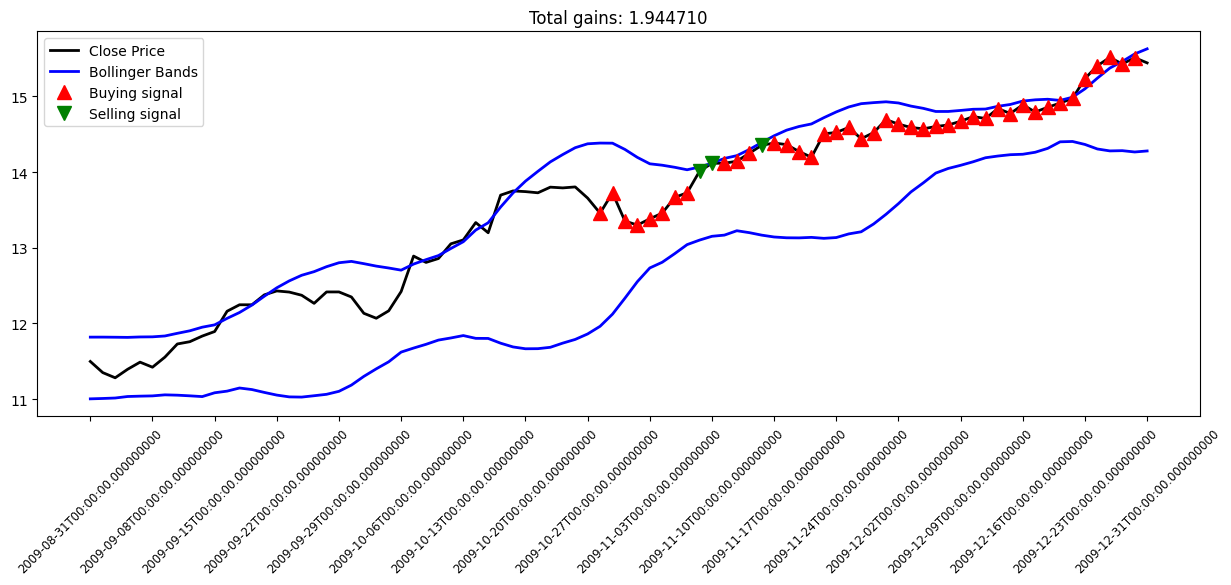

In [63]:
# Plot improved results
plot_behavior(
    X_test_true_price,
    X_test_true_bb_upper,
    X_test_true_bb_lower,
    states_buy_test_improved,
    states_sell_test_improved,
    total_profit_improved,
    train=False,
)